In [35]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score

In [36]:
df = pd.read_csv('./../data/preprocessed_matches.csv')
df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
0,803169,2015,2015-08-08 12:45:00,Manchester United,1,1,Tottenham Hotspur,6,0,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
1,803170,2015,2015-08-08 15:00:00,Everton,11,2,Watford,57,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
2,803162,2015,2015-08-08 15:00:00,Bournemouth,91,0,Aston Villa,7,1,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
3,803163,2015,2015-08-08 15:00:00,Norwich City,45,1,Crystal Palace,31,3,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
4,803167,2015,2015-08-08 15:00:00,Leicester City,13,4,Sunderland,56,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0


In [37]:
features = [
    'elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
    'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
    'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
]

In [38]:
# Remove 2015 (first season) from dataset because h2h calculations can't be performed (reasonably) without past games
df = df[df['season'] != 2015]
df['season'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [39]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "seed": 42,
    "learning_rate": 0.010007280241691709,
    "num_leaves": 127,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
}

In [40]:
# Timeseries Cross-Validation
seasons = df["season"].unique()
fold_accuracy = []
fold_logloss = []
fold_precision = []
fold_recall = []
train_sizes = []
train_scores = []
test_scores = []

for i in range(1, len(seasons)):
    train_df = df[df["season"].isin(seasons[:i])]
    test_df = df[df["season"].isin([seasons[i]])]

    X_train = train_df[features]
    y_train = train_df['target']
    X_test = test_df[features]
    y_test = test_df['target']

    lgb_tr = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, lgb_tr, num_boost_round=1000)

    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    pred_labels = (preds_test >= 0.5).astype(int)


    fold_accuracy.append(accuracy_score(y_test, pred_labels))
    fold_logloss.append(log_loss(y_test, preds_test))
    fold_precision.append(precision_score(y_test, pred_labels, average='binary'))
    fold_recall.append(recall_score(y_test, pred_labels, average='binary'))
    print(f"Lightgbm(n_estimators=500, max_depth=50) \n"
          f"Train({seasons[:i]}) with Test ({[seasons[i]]} \n"
          f"Accuracy: {accuracy_score(y_test, pred_labels)}, "
          f"Logloss: {log_loss(y_test, preds_test)}, "
          f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
          f"Recall: {recall_score(y_test, pred_labels, average='binary')}")

    train_sizes.append(len(train_df))
    test_scores.append(log_loss(y_test, preds_test))
    train_scores.append(log_loss(y_train, preds_train))

print("---------------------------Final---------------------------")
print(f"RandomForstClassifier(n_estimators=500, max_depth=50) "
      f"Accuracy: {np.mean(fold_accuracy)}, Logloss: {np.mean(fold_logloss)}, Precision: {np.mean(fold_precision)}, Recall: {np.mean(fold_recall)}")

Lightgbm(n_estimators=500, max_depth=50) 
Train([2016]) with Test ([2017] 
Accuracy: 0.7473684210526316, Logloss: 0.5175205457575912, Precision: 0.5681818181818182, Recall: 0.46296296296296297
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017]) with Test ([2018] 
Accuracy: 0.7342105263157894, Logloss: 0.5588151906939499, Precision: 0.6588235294117647, Recall: 0.4375
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018]) with Test ([2019] 
Accuracy: 0.7131578947368421, Logloss: 0.582159628923333, Precision: 0.5384615384615384, Recall: 0.4224137931034483
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019]) with Test ([2020] 
Accuracy: 0.6289473684210526, Logloss: 0.7565669789423309, Precision: 0.5833333333333334, Recall: 0.27450980392156865
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020]) with Test ([2021] 
Accuracy: 0.7263157894736842, Logloss: 0.5589938254355034, Precision: 0.6288659793814433, Recall: 0.4728682170542636
L

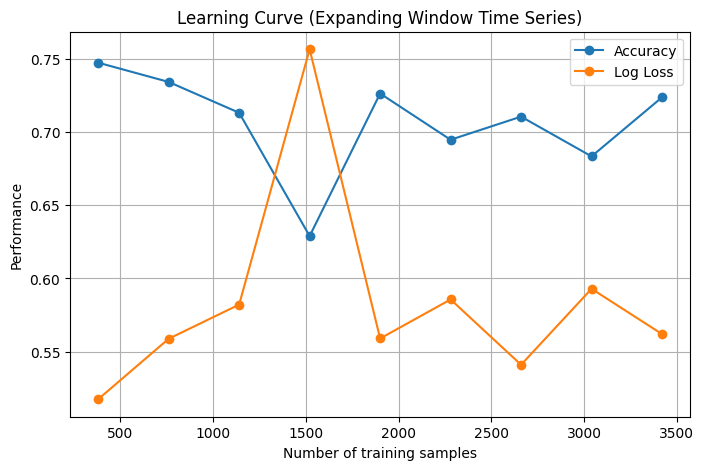

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, fold_accuracy, marker='o', label="Accuracy")
plt.plot(train_sizes, fold_logloss, marker='o', label="Log Loss")

plt.xlabel("Number of training samples")
plt.ylabel("Performance")
plt.title("Learning Curve (Expanding Window Time Series)")
plt.legend()
plt.grid(True)
plt.show()

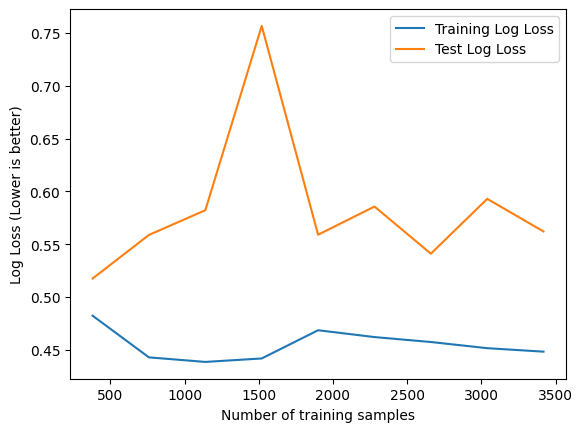

In [42]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores, label="Training Log Loss")
plt.plot(train_sizes, test_scores, label="Test Log Loss")
plt.xlabel("Number of training samples")
plt.ylabel("Log Loss (Lower is better)")
plt.legend()
plt.show()

In [43]:
train_seasons = seasons[:-1]
test_season = seasons[-1]
train_seasons, test_season

(array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]), 2025)

In [44]:
train_df = df[df["season"].isin(train_seasons)]
test_df = df[df["season"].isin([test_season])]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

lgb_tr = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, lgb_tr, num_boost_round=1000)

preds_test = model.predict(X_test)

pred_labels = (preds_test >= 0.5).astype(int)

fold_accuracy.append(accuracy_score(y_test, pred_labels))
fold_logloss.append(log_loss(y_test, preds_test))
fold_precision.append(precision_score(y_test, pred_labels, average='binary'))
fold_recall.append(recall_score(y_test, pred_labels, average='binary'))
print(f"Lightgbm(n_estimators=500, max_depth=50) \n"
    f"Train({seasons[:i]}) with Test ({[seasons[i]]} \n"
    f"Accuracy: {accuracy_score(y_test, pred_labels)}, "
    f"Logloss: {log_loss(y_test, preds_test)}, "
    f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
    f"Recall: {recall_score(y_test, pred_labels, average='binary')}")


Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020 2021 2022 2023 2024]) with Test ([2025] 
Accuracy: 0.7236180904522613, Logloss: 0.5620943894912938, Precision: 0.5476190476190477, Recall: 0.3898305084745763
